# Telecom Churn Case Study

Goal :
- Build ML models to predict whether high value customer will churn or not,in near future.
- Identify important variables that are strong predictors of churn.
- Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, 
    recall, etc. for the different models that can be used for evaluation purposes based on different business objectives.
- Recommend strategies to manage customer churn based on observations

Data : https://www.kaggle.com/competitions/telecom-churn-case-study-hackathon-c35
        

In [58]:
# Suppress Warnings

import warnings
warnings.filterwarnings('ignore')

# import libs
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import xgboost as xgb  # Load this xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import time

# Start Time 
st = time.time()

# Read the dataset (tc = telecom churn)
tc = pd.read_csv("train.csv")
tc.head()

# id is Customer ID
# Target Variable - churn_probability

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [59]:
tc.shape

# 69999 - Rows (Entries)
# 172 - Columns (Features)

(69999, 172)

In [60]:
tc.info(verbose=True,null_counts=True)

# Observed some variables have Null Values, so need to analyse the business relevance and decide on to drop or impute missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [61]:
tc.describe()

# Seems some of the variables like loc_og_t2o_mou, std_og_t2o_mou, loc_ic_t2o_mou have just 0 for all min, max, mean ...
# so this indicates that it has only 1 unique value

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


Data Cleaning - Fixing Rows and Columns

In [62]:
# Check for Null values
tc_null = ((tc.isnull().sum()/tc.shape[0])*100).sort_values(ascending=False)

# Filter the features which has > 70% of Null values
tc_null = tc_null[tc_null > 70].keys()
tc_null

# Below columns listed by tc_null can be dropped based on thier *Business Significance* as they have > 70% NULL values.

Index(['arpu_3g_6', 'count_rech_2g_6', 'night_pck_user_6', 'arpu_2g_6',
       'date_of_last_rech_data_6', 'total_rech_data_6', 'av_rech_amt_data_6',
       'max_rech_data_6', 'count_rech_3g_6', 'fb_user_6', 'night_pck_user_7',
       'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7',
       'fb_user_7', 'count_rech_2g_7', 'count_rech_3g_7', 'arpu_3g_7',
       'av_rech_amt_data_7', 'arpu_2g_7', 'count_rech_2g_8',
       'av_rech_amt_data_8', 'night_pck_user_8', 'max_rech_data_8',
       'total_rech_data_8', 'arpu_2g_8', 'arpu_3g_8',
       'date_of_last_rech_data_8', 'fb_user_8', 'count_rech_3g_8'],
      dtype='object')

Some of the features can be dropped as below
- fb_user_6, fb_user_7, fb_user_8 : As Facebook usage is covered as part of Data usage so we can Drop this columns.
- date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8 : Date of Last reacharge doesn't give much info as the recharge data is covered by Max and Total Recharge Data columns. So we can Drop this column

For other columns, we should keep them and fill in 0 for all Blank info as it means 0 reacharge amt or count 

In [63]:
# Columns to Drop as listed above
tc = tc.drop(['fb_user_6','fb_user_7','fb_user_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1)
tc.shape

(69999, 166)

In [64]:
# For other columns, we should keep them and fill in 0 for all Blank info as it means 0 reacharge amt or count 

tc_retain= ['arpu_3g_6', 'count_rech_2g_6', 'night_pck_user_6', 'arpu_2g_6',
            'total_rech_data_6', 'av_rech_amt_data_6',
            'max_rech_data_6', 'count_rech_3g_6', 'night_pck_user_7',
            'total_rech_data_7', 'max_rech_data_7',
            'count_rech_2g_7', 'count_rech_3g_7', 'arpu_3g_7',
            'av_rech_amt_data_7', 'arpu_2g_7', 'count_rech_2g_8',
            'av_rech_amt_data_8', 'night_pck_user_8', 'max_rech_data_8',
            'total_rech_data_8', 'arpu_2g_8', 'arpu_3g_8', 'count_rech_3g_8']

# Fill 0 to all Blank info
tc[tc_retain] = tc[tc_retain].fillna(0)
tc[tc_retain] 

,arpu_3g_6,count_rech_2g_6,night_pck_user_6,arpu_2g_6,total_rech_data_6,av_rech_amt_data_6,max_rech_data_6,count_rech_3g_6,night_pck_user_7,total_rech_data_7,...,av_rech_amt_data_7,arpu_2g_7,count_rech_2g_8,av_rech_amt_data_8,night_pck_user_8,max_rech_data_8,total_rech_data_8,arpu_2g_8,arpu_3g_8,count_rech_3g_8
0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,...,145.0,122.08,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
4,0.00,7.0,0.0,0.00,7.0,175.0,25.0,0.0,0.0,7.0,...,191.0,35.12,6.0,142.0,0.0,25.0,6.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,7.0,...,135.0,60.61,1.0,17.0,0.0,17.0,1.0,48.00,0.00,0.0
69995,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
69996,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
69997,150.67,0.0,0.0,150.67,1.0,179.0,179.0,1.0,0.0,1.0,...,252.0,212.17,0.0,145.0,0.0,145.0,1.0,122.07,122.08,1.0


In [65]:
# Check for further Null values as there are columns with less than 5.29% Null values.
# Let's interpret these columns business value and decide whether to drop rows or impute 0s to all .

tc_null = ((tc.isnull().sum()/tc.shape[0])*100).sort_values(ascending=False)

# Filter the features which has any Null values .i.e. tc.isnull().sum() greater than 0 which means it has Null values. 
tc_null = tc_null[tc_null > 0].keys()

tc[tc_null] = tc[tc_null].fillna(0)
tc[tc_null]

,roam_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2c_mou_8,loc_ic_t2m_mou_8,loc_og_t2t_mou_8,loc_ic_t2f_mou_8,std_og_t2f_mou_8,...,loc_ic_t2t_mou_7,loc_og_t2m_mou_7,date_of_last_rech_8,date_of_last_rech_7,date_of_last_rech_6,last_date_of_month_8,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_7
0,0.00,0.00,0.0,7.79,2.33,0.00,16.91,0.28,0.00,0.0,...,3.68,16.04,8/24/2014,7/10/2014,6/22/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
1,0.00,31.66,0.0,10.53,0.00,29.79,11.09,0.00,3.40,0.0,...,19.09,0.00,8/26/2014,7/10/2014,6/12/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
2,0.00,0.00,0.0,6.49,0.00,0.00,23.51,0.00,0.00,0.0,...,6.16,0.00,8/24/2014,7/22/2014,6/11/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
3,1.63,25.61,0.0,23.88,23.63,8.03,57.14,0.00,0.00,0.0,...,4.84,44.89,8/25/2014,7/21/2014,6/15/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
4,0.00,0.00,0.0,2.66,4.61,0.00,19.49,6.13,6.14,0.0,...,1.39,19.88,8/30/2014,7/26/2014,6/25/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,0.00,1.83,0.0,33.84,89.66,0.86,223.91,7.19,0.00,0.0,...,26.59,60.64,8/31/2014,7/31/2014,6/18/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
69995,0.00,0.18,0.0,23.09,47.34,0.00,28.79,9.06,0.00,0.0,...,28.48,73.84,8/27/2014,7/31/2014,6/28/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
69996,0.00,0.00,0.0,86.53,138.26,0.00,177.73,78.44,147.74,0.0,...,30.29,82.58,8/29/2014,7/30/2014,6/25/2014,8/31/2014,0.0,0.0,0.0,7/31/2014
69997,0.00,0.00,0.0,1.04,8.84,0.00,3.94,6.71,2.81,0.0,...,3.64,6.66,8/26/2014,7/19/2014,6/29/2014,8/31/2014,0.0,0.0,0.0,7/31/2014


In [66]:
# Check for Unique values in the features/columns
tc_nunique = tc.nunique().sort_values()

# Filter the features which has just 1 unique value as these columns can be dropped as with just 1 value 
# it doesn't give much information.
tc_nunique = tc_nunique[tc_nunique == 1].keys()

# drop the columns which has just 1 unique value as these columns can be dropped as with just 1 value 
# it doesn't give much information.
tc = tc.drop(tc_nunique, axis=1)
tc.shape

(69999, 155)

In [67]:
tc.info(verbose=True,null_counts=True)

# all the features have no Nan values and data imputation is done .

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 155 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    69999 non-null  int64  
 1    last_date_of_month_7  69999 non-null  object 
 2    last_date_of_month_8  69999 non-null  object 
 3    arpu_6                69999 non-null  float64
 4    arpu_7                69999 non-null  float64
 5    arpu_8                69999 non-null  float64
 6    onnet_mou_6           69999 non-null  float64
 7    onnet_mou_7           69999 non-null  float64
 8    onnet_mou_8           69999 non-null  float64
 9    offnet_mou_6          69999 non-null  float64
 10   offnet_mou_7          69999 non-null  float64
 11   offnet_mou_8          69999 non-null  float64
 12   roam_ic_mou_6         69999 non-null  float64
 13   roam_ic_mou_7         69999 non-null  float64
 14   roam_ic_mou_8         69999 non-null  float64
 15   

Drop all the last_date features as it only says that amount recharged or date of last recharge which is a single instances
of the customer and doesn't give much info on the customer behaviour w.r.t frequency of recharge interms of amount or date 


In [68]:
# Drop all the 'last_date' features as it only says that amount recharged or date of last recharge which is a single instances 
# of the customer and doesn't give much info on the customer behaviour w.r.t frequency of recharge interms of amount or date

last_date = ['last_date_of_month_7','last_date_of_month_8','date_of_last_rech_6','date_of_last_rech_7',
              'date_of_last_rech_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

tc = tc.drop(last_date, axis=1)

tc.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 147 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    id                  69999 non-null  int64  
 1    arpu_6              69999 non-null  float64
 2    arpu_7              69999 non-null  float64
 3    arpu_8              69999 non-null  float64
 4    onnet_mou_6         69999 non-null  float64
 5    onnet_mou_7         69999 non-null  float64
 6    onnet_mou_8         69999 non-null  float64
 7    offnet_mou_6        69999 non-null  float64
 8    offnet_mou_7        69999 non-null  float64
 9    offnet_mou_8        69999 non-null  float64
 10   roam_ic_mou_6       69999 non-null  float64
 11   roam_ic_mou_7       69999 non-null  float64
 12   roam_ic_mou_8       69999 non-null  float64
 13   roam_og_mou_6       69999 non-null  float64
 14   roam_og_mou_7       69999 non-null  float64
 15   roam_og_mou_8       69999 non-null

In [69]:
######################################################################################################
# Feature engineering 
# total_rech_amt_data_* =  total_rech_data_*  *  av_rech_amt_data_*
# total_rech_data_6 = count_rech_2g_6 + count_rech_3g_6 - So, count_reach_2g/3g* Can be Dropped
########################################################################################################

In [70]:
######################################################################################################
# Feature engineering 
# total_rech_amt_data_* =  total_rech_data_*  *  av_rech_amt_data_*
# total_rech_data_6 = count_rech_2g_6 + count_rech_3g_6 - So, count_reach_2g/3g* Can be Dropped
########################################################################################################
tc['total_rech_amt_data_6'] = tc['total_rech_data_6'] * tc['av_rech_amt_data_6']
tc['total_rech_amt_data_7'] = tc['total_rech_data_7'] * tc['av_rech_amt_data_7']
tc['total_rech_amt_data_8'] = tc['total_rech_data_8'] * tc['av_rech_amt_data_8']

drop_feat_count_avg = ['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
                  'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_7' , 'id']
tc = tc.drop(drop_feat_count_avg, axis=1)

# Reference list of features to be used for unseen test dataset
final_vars = tc.drop('churn_probability', axis=1).columns

tc.shape

(69999, 141)

In [71]:
# Dump Final Variables after Data Cleaning

final_vars

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'total_rech_amt_data_6',
       'total_rech_amt_data_7', 'total_rech_amt_data_8'],
      dtype='object', length=140)

In [72]:
# Check Correlation

#plt.figure(figsize = (20,10))        # Size of the figure
#sns.heatmap(tc.corr(),annot = True)
#plt.show()

# There seems to be a lot of correlation b/w the variables as we see more Light color in the corr matrix 


In [73]:
# Split Train and Test dataset and Feature Scaling
tc_train, tc_test = train_test_split(tc, train_size=0.8, random_state=100)

Feature_list = tc_train.select_dtypes(include=['float64', 'int64'])
Feature_list = tc_train.drop('churn_probability', axis=1).columns

# Feature Scaling
scaler = MinMaxScaler()
tc_train[Feature_list] = scaler.fit_transform(tc_train[Feature_list])
tc_test[Feature_list] = scaler.transform(tc_test[Feature_list])

Feature_list

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'total_rech_amt_data_6',
       'total_rech_amt_data_7', 'total_rech_amt_data_8'],
      dtype='object', length=140)

In [74]:
# Create X and y variables 
y_train = tc_train.pop('churn_probability')
X_train = tc_train 

y_test = tc_test.pop('churn_probability')
X_test = tc_test 

y_train

59805    1
32717    0
5964     0
47623    0
31881    0
        ..
14260    0
63370    0
65615    0
56088    0
38408    0
Name: churn_probability, Length: 55999, dtype: int64

In [75]:
# Before Model building as we see multi-collinearity b/w the variables and we also need to do dimensionality reduction so we
# run PCA

pca = PCA(random_state=100)

pca.fit(X_train)
pca.components_

array([[ 1.18936643e-03,  7.55001383e-04,  1.31065128e-03, ...,
        -2.49614870e-03, -3.72061736e-03, -1.87393624e-03],
       [ 5.14573039e-02,  4.66923882e-02,  4.36902443e-02, ...,
         6.92630244e-03,  1.27800751e-02,  6.70204688e-03],
       [ 1.86000587e-02,  1.62226166e-02,  1.91268475e-02, ...,
         4.66578475e-02,  6.66474678e-02,  3.39620641e-02],
       ...,
       [ 0.00000000e+00, -2.01406130e-16, -4.81492557e-16, ...,
        -7.94995430e-17, -4.50814863e-19, -2.93322792e-18],
       [ 0.00000000e+00, -1.70368275e-16,  2.83511456e-16, ...,
         2.25998575e-17,  3.46980930e-17, -1.99869181e-16],
       [-0.00000000e+00, -3.18709798e-15, -3.06140628e-16, ...,
         2.67355225e-16, -1.12650047e-15,  2.39751743e-16]])

In [76]:
pca.explained_variance_ratio_

array([2.95057516e-01, 1.08453822e-01, 8.32343262e-02, 6.01662612e-02,
       4.78480540e-02, 3.87069782e-02, 3.63787143e-02, 2.77667467e-02,
       2.16671275e-02, 2.02853028e-02, 1.95748143e-02, 1.66077662e-02,
       1.57028351e-02, 1.43711928e-02, 1.24610770e-02, 1.18986734e-02,
       9.41999061e-03, 8.84457916e-03, 7.95491713e-03, 7.65480380e-03,
       6.60317502e-03, 6.36330057e-03, 5.93345461e-03, 5.69610615e-03,
       5.49699531e-03, 5.03065145e-03, 4.99147640e-03, 4.88088917e-03,
       4.58802594e-03, 4.40862281e-03, 4.22084174e-03, 4.13168223e-03,
       3.78949701e-03, 3.50552621e-03, 3.26168920e-03, 3.08331568e-03,
       2.93902030e-03, 2.73595849e-03, 2.63500331e-03, 2.48153025e-03,
       2.36474234e-03, 2.20516394e-03, 2.02482970e-03, 1.95369801e-03,
       1.85315288e-03, 1.73694439e-03, 1.70544956e-03, 1.67652921e-03,
       1.58510181e-03, 1.41435338e-03, 1.38523546e-03, 1.32400307e-03,
       1.29218988e-03, 1.27194152e-03, 1.24284003e-03, 1.19797676e-03,
      

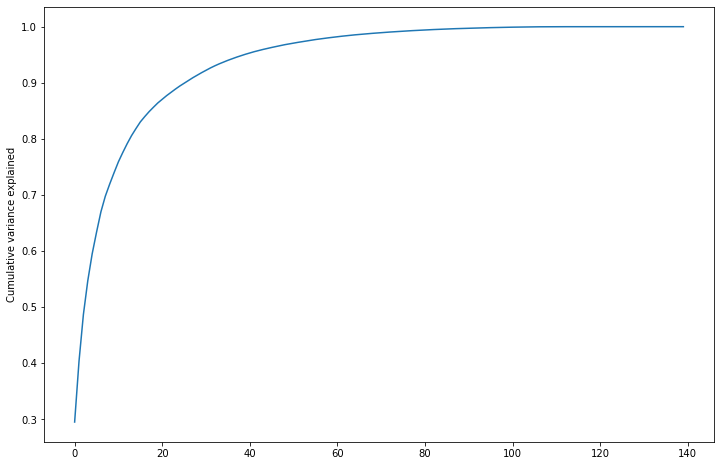

In [77]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [78]:
# Perform PCA with 30 Variables using IncrementalPCA

pca_final = IncrementalPCA(n_components=30)
tc_train_pca = pca_final.fit_transform(X_train)
tc_train_pca.shape

(55999, 30)

In [79]:
tc_test_pca = pca_final.transform(X_test)
tc_test_pca.shape

(14000, 30)

In [80]:
# Print the accuracy, precision, recall score

def print_score(y_test, y_test_pred):
    print('Accuracy Score :', accuracy_score(y_test, y_test_pred))
    print('Precision Score :', precision_score(y_test, y_test_pred))
    print('Recall Score :', recall_score(y_test, y_test_pred))
    print('Roc AUC Score :', roc_auc_score(y_test, y_test_pred))

In [81]:
# Applying XGBoost on the data on our Principal components
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, objective = 'binary:logistic')
# Fit the model to our train and target
xgb_cfl.fit(tc_train_pca, y_train)  # default 
# Get our predictions
y_test_pred = xgb_cfl.predict(tc_test_pca)

[23:59:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [82]:
print('====== Model 1 : XGBOOST========')
print_score(y_test, y_test_pred)

====== Model 1 : XGBOOST========
Accuracy Score : 0.9209285714285714
Precision Score : 0.6550598476605005
Recall Score : 0.4324712643678161
Roc AUC Score : 0.7036642489351771


In [83]:
# Model 2 : LogisticRegression()
lr = LogisticRegression()
lr.fit(tc_train_pca, y_train)
y_test_pred1 = lr.predict(tc_test_pca)

In [84]:
print('======Model 2 : LogisticRegression ========')
print_score(y_test, y_test_pred1)

======Model 2 : LogisticRegression ========
Accuracy Score : 0.9037142857142857
Precision Score : 0.5964912280701754
Recall Score : 0.09770114942528736
Roc AUC Score : 0.5452020975552833


In [85]:
# Model 2 : LogisticRegression()
rf = RandomForestClassifier()
rf.fit(tc_train_pca, y_train)
y_test_pred2 = rf.predict(tc_test_pca)

In [86]:
print('======Model 3 : RandomForrest ========')
print_score(y_test, y_test_pred2)

======Model 3 : RandomForrest ========
Accuracy Score : 0.9183571428571429
Precision Score : 0.6936236391912908
Recall Score : 0.3204022988505747
Roc AUC Score : 0.6523886494252873


# Model 1 PCA + XGBoost has better accuracy of 92.0% so it's the Final model . 
# Also Precision Score - Determines Actual Churns is around 65.5%

In [87]:
# Will choose XGBoost and do Hyperparam tuning on XGBoost
# A parameter grid for XGBoost
# CPU and Memory Intensive operation
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5

param_comb = 2

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=100)

In [88]:
random_search.fit(tc_train_pca, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[00:09:20] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimat...
                                           tree_method='exact',
                                           validate_parameters=1,
       

In [89]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

 Best accuracy for 5-fold search with 2 parameter combinations:
0.9176414140930952

 Best hyperparameters:
{'subsample': 1.0, 'n_estimators': 750, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [90]:
y_test_pred3 = random_search.predict(tc_test_pca)
print('====== Model 1 : XGBOOST : Hyperparam tune ========')
print_score(y_test, y_test_pred3)

====== Model 1 : XGBOOST : Hyperparam tune ========
Accuracy Score : 0.9205714285714286
Precision Score : 0.6548672566371682
Recall Score : 0.42528735632183906
Roc AUC Score : 0.7002705817142191


Import test.csv + remove all features as in Train + Feature scale + PCA Transform + use XBoost Predict 
Use final_vars as feature list before applying PCA 
Read the Unseen Test dataset (tc = telecom churn)

In [91]:
# Import test.csv + remove all features as in Train + use XBoost 
#final_vars
# Read the Unseen Test dataset (tc = telecom churn)
tc_unseen = pd.read_csv("test_unseen.csv")
tc_unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [92]:
submit_tc = tc_unseen[['id']]

In [93]:
submit_tc['id'] = tc_unseen[['id']].copy()

tc_unseen['total_rech_amt_data_6'] = tc_unseen['total_rech_data_6'] * tc_unseen['av_rech_amt_data_6']
tc_unseen['total_rech_amt_data_7'] = tc_unseen['total_rech_data_7'] * tc_unseen['av_rech_amt_data_7']
tc_unseen['total_rech_amt_data_8'] = tc_unseen['total_rech_data_8'] * tc_unseen['av_rech_amt_data_8']

# only take final_vars variables after Data cleaning done earlier
tc_unseen = tc_unseen[final_vars]

# Fill 0 for NUll value Treatment  
tc_unseen =tc_unseen.fillna(0)

# Feature Scaling for unseen data as done earlier for test data 
tc_unseen[final_vars] = scaler.transform(tc_unseen[final_vars])

submit_tc.head()

,id
0,69999
1,70000
2,70001
3,70002
4,70003


In [94]:
# Once Feature scaling is done, use the dataset with PCA for Dimensionalisty reduction and use Transform
tc_test_unseen_pca = pca_final.transform(tc_unseen)

# Use XGBoost.predict to get Churn predictions and store in new column
tc_unseen['churn_probability'] = xgb_cfl.predict(tc_test_unseen_pca).astype('int64')
tc_unseen.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,churn_probability
0,0.078380,0.037190,0.029292,0.004308,0.002525,0.002149,0.010188,0.004771,0.002487,0.000000,...,0.0,0.0,0.365306,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
1,0.089126,0.049547,0.037886,0.010236,0.005144,0.001845,0.080327,0.092260,0.028195,0.000000,...,0.0,0.0,0.568495,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
2,0.086314,0.047333,0.049060,0.001022,0.000981,0.000781,0.002875,0.006797,0.003215,0.008001,...,0.0,0.0,0.023436,0.06201,0.082745,0.021658,0.0,0.0,0.0,1
3,0.076768,0.040101,0.028131,0.000720,0.000270,0.000000,0.006781,0.030417,0.001714,0.000000,...,0.0,0.0,0.257067,0.00000,0.000000,0.000000,0.0,0.0,0.0,0
4,0.085548,0.046548,0.039407,0.061129,0.076016,0.065164,0.010320,0.003537,0.005294,0.000000,...,0.0,0.0,0.068132,0.00000,0.000000,0.000000,0.0,0.0,0.0,0


In [95]:
# Concat churn prob with id in submit_tc

submit_tc = pd.concat([submit_tc['id'], tc_unseen[['churn_probability']]], axis=1)
submit_tc.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [96]:
y_pred_unseen = tc_unseen[['churn_probability']]
y_pred_unseen

,churn_probability
0,0
1,0
2,1
3,0
4,0
...,...
29995,0
29996,0
29997,0
29998,0


In [97]:
submit_tc.to_csv('telecom_churn_submission.csv', index=False)

Now Run RFE + Logistic Regression and RFE + Random Forrest for Feature importance

In [98]:
# CPU and Memory Intensive operation
from sklearn.feature_selection import RFE

rfe = RFE(LogisticRegression(random_state=100, n_jobs=-1), n_features_to_select=30)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 13),
 ('arpu_8', False, 40),
 ('onnet_mou_6', False, 43),
 ('onnet_mou_7', False, 32),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 44),
 ('offnet_mou_7', False, 31),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', True, 1),
 ('roam_ic_mou_7', False, 36),
 ('roam_ic_mou_8', False, 11),
 ('roam_og_mou_6', False, 12),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 99),
 ('loc_og_t2t_mou_7', False, 74),
 ('loc_og_t2t_mou_8', False, 5),
 ('loc_og_t2m_mou_6', False, 82),
 ('loc_og_t2m_mou_7', False, 24),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 73),
 ('loc_og_t2f_mou_7', False, 100),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 25),
 ('loc_og_t2c_mou_7', False, 50),
 ('loc_og_t2c_mou_8', False, 39),
 ('loc_og_mou_6', False, 89),
 ('loc_og_mou_7', False, 33),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 61),
 ('std_og_t2t_mou_7', False, 49),
 ('std_og_t2t_mou

In [99]:
# Copy the RFE recommended columns to X_train_ref_name variable to have the list of Columns
X_train_rfe_name = X_train.columns[rfe.support_]

# Use above X_train_ref_name list of columns and copy only that dataset from those columns to X_train_rfe
X_train_rfe = X_train[X_train_rfe_name]

X_test_rfe = X_test[X_train_rfe_name]

X_train_rfe_name

Index(['arpu_6', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'spl_og_mou_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_8', 'std_ic_t2m_mou_8', 'std_ic_mou_8', 'total_ic_mou_8',
       'spl_ic_mou_7', 'spl_ic_mou_8', 'total_rech_num_6', 'total_rech_num_8',
       'total_rech_amt_6', 'max_rech_amt_8', 'total_rech_data_8',
       'monthly_2g_8', 'sachet_2g_8'],
      dtype='object')

In [100]:
lr2 = LogisticRegression()
lr2.fit(X_train_rfe, y_train)
y_test_pred4 = lr2.predict(X_test_rfe)

In [101]:
print('======Model 5 : LogisticRegression + RFE ========')
print_score(y_test, y_test_pred4)

======Model 5 : LogisticRegression + RFE ========
Accuracy Score : 0.9022857142857142
Precision Score : 0.575
Recall Score : 0.06609195402298851
Roc AUC Score : 0.53034927650388


RFE + RandomForrestClassifier for Feature elimination and Feature selection

In [102]:
# CPU and Memory Intensive operation
rf1 = RFE(RandomForestClassifier(random_state=100, n_jobs=-1), n_features_to_select=30)
rf1.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(n_jobs=-1, random_state=100),
    n_features_to_select=30)

In [103]:
# Copy the RFE recommended columns to features variable to have the list of Columns
features = X_train.columns[rf1.get_support()]
features

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_8', 'aon'],
      dtype='object')

In [104]:
# Use above features list of columns and copy only that dataset from those columns to X_train_rfe_rf
X_train_rfe_rf = X_train[features]
X_test_rfe_rf = X_test[features]

X_train_rfe_rf

,arpu_6,arpu_7,arpu_8,onnet_mou_6,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2m_mou_8,...,loc_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_rech_num_7,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_8,aon
59805,0.075983,0.047947,0.027423,0.000000,0.000000,0.019626,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006350,0.000006,0.007246,0.000000,0.000000,0.000000,0.000000,0.144479
32717,0.080579,0.040280,0.029656,0.037549,0.048319,0.021614,0.009892,0.000000,0.000000,0.027912,...,0.035612,0.153540,0.055654,0.035948,0.036232,0.005683,0.003967,0.002868,0.038247,0.275912
5964,0.085620,0.048250,0.039387,0.004288,0.020746,0.031974,0.002637,0.002947,0.000000,0.005158,...,0.010095,0.028911,0.037333,0.021951,0.065217,0.008213,0.013140,0.013813,0.058252,0.329307
47623,0.080455,0.037052,0.035133,0.007272,0.019442,0.006007,0.017122,0.000000,0.000000,0.047796,...,0.049711,0.036986,0.006318,0.049710,0.014493,0.005115,0.001735,0.006840,0.014710,0.163566
31881,0.082919,0.041503,0.032657,0.001554,0.024303,0.022943,0.007355,0.000000,0.000000,0.008336,...,0.013022,0.042155,0.052870,0.048476,0.123188,0.007701,0.006694,0.003795,0.012062,0.215511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14260,0.078167,0.036591,0.037836,0.000000,0.009287,0.003721,0.017120,0.000000,0.000000,0.002612,...,0.003000,0.000000,0.001282,0.007921,0.014493,0.000000,0.001240,0.012268,0.029420,0.013047
63370,0.098141,0.054815,0.063029,0.008315,0.075441,0.055928,0.067178,0.018943,0.041857,0.072265,...,0.038572,0.070653,0.053720,0.048414,0.043478,0.029241,0.016487,0.033451,0.102677,0.380043
65615,0.081032,0.040517,0.031776,0.001815,0.016936,0.016200,0.004748,0.000000,0.000000,0.013033,...,0.003877,0.008833,0.015350,0.004223,0.036232,0.004263,0.006446,0.003310,0.044131,0.473303
56088,0.087795,0.043838,0.035598,0.003038,0.023749,0.018202,0.006078,0.000000,0.000000,0.006593,...,0.002342,0.004670,0.002870,0.003045,0.028986,0.007161,0.008553,0.011077,0.074139,0.289683


In [105]:
# Now Run RFE + Random Forrest Classifier for Feature importance
rf2 = RandomForestClassifier()
rf2.fit(X_train_rfe_rf, y_train)

RandomForestClassifier()

In [106]:
print('======Model 6 : RandomForestClassifier + RFE ========')
y_test_pred6 = rf2.predict(X_test_rfe_rf)
print_score(y_test, y_test_pred6)

======Model 6 : RandomForestClassifier + RFE ========
Accuracy Score : 0.9428571428571428
Precision Score : 0.7862669245647969
Recall Score : 0.584051724137931
Roc AUC Score : 0.7832615854192193


Features impacting the churn 

In [107]:
# Features impacting the churn
features

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'max_rech_amt_8', 'aon'],
      dtype='object')

In [110]:
# End Time 
et = time.time()
elapsed_time = et-st
#print('Execution Time:', elapsed_time, 'seconds')